In [1]:
import pandas as pd
import numpy as np
import math as math
import random
from sklearn.utils import shuffle
import sklearn.preprocessing  as prepro
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.utils import resample
from sklearn.cluster import KMeans
from imblearn.over_sampling import SMOTE
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.lines as mlines
from xgboost import XGBClassifier
# from adjustText import adjust_text


#constants
random_state = 42
plotColor = ['b','g','r','m','c', 'y']
markers = ['+','o','*','^','v','>','<']

#set up
sns.set(style='whitegrid')
%matplotlib inline

In [2]:
data_scaled = pd.read_csv("telecom_data_preprocessed.csv")
data_scaled = data_scaled.drop(columns="Unnamed: 0")

In [3]:
X = data_scaled.drop(columns="Churn")
y = data_scaled["Churn"]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=42)
print("----------------------------")
print("Original features shape, ", X.shape)
print("Original target shape, ", y.shape)
print("x train shape, ", X_train.shape)
print("y train shape, ", y_train.shape)
print("x test shape, ", X_test.shape)
print("y test shape, ", y_test.shape)
print("----------------------------")

----------------------------
Original features shape,  (7032, 28)
Original target shape,  (7032,)
x train shape,  (5625, 28)
y train shape,  (5625,)
x test shape,  (1407, 28)
y test shape,  (1407,)
----------------------------


In [4]:
smote = SMOTE(random_state=42)
X_train_upsampled , y_train_upsampled = smote.fit_resample(X_train,y_train)
print("----------------------------")
print("Original x train shape, ", X_train.shape)
print("Resample x train shape, ", X_train_upsampled.shape)
print("----------------------------")

----------------------------
Original x train shape,  (5625, 28)
Resample x train shape,  (8260, 28)
----------------------------


In [5]:
import yaml

# Load the YAML file
with open('../../model_artifact/training/telco/oversampling.yaml', 'r') as file:
    config = yaml.safe_load(file)

# Get the list of models
models = config["models"]

# Extract hyperparameters for each model
os_random_forest_params = next(model['hyperparameters'] for model in models if model['name'] == 'Random Forest')
os_random_forest_threshold = 0.4449

# Print the hyperparameters for each model
print("Random Forest Parameters:", os_random_forest_params)
print(f"Random Forest Threshold: {os_random_forest_threshold} ")

# Build model and evaluate
xai_model = RandomForestClassifier(**os_random_forest_params)
trained_xai_model = xai_model.fit(X_train_upsampled, y_train_upsampled)

Random Forest Parameters: {'criterion': 'entropy', 'max_depth': 8, 'min_samples_leaf': 7, 'n_estimators': 400}
Random Forest Threshold: 0.4449 


In [6]:
import shap
shap.initjs()

In [7]:
# For correct set
explainer = shap.TreeExplainer(model=trained_xai_model,data=X_train_upsampled,model_output="probability")

In [8]:
# #explainer_ndarray = explainer.shap_values(X_test)
# explainer_object = explainer(X_test)

In [9]:
# import pickle

# # Save the explainer object using pickle
# with open("telco_explainer.pkl", "wb") as f:
#     pickle.dump(explainer_object, f)


In [10]:
import pickle
# Load the explainer object using pickle
with open("../../model_artifact/training/telco/telco_explainer.pkl", "rb") as f:
    explainer_object = pickle.load(f)

In [11]:
explainer_object

.values =
array([[[ 3.25803066e-03, -3.25803124e-03],
        [ 1.68828545e-02, -1.68828552e-02],
        [-6.65280335e-03,  6.65280361e-03],
        ...,
        [-4.59715897e-03,  4.59715903e-03],
        [-1.49532368e-03,  1.49532393e-03],
        [-4.47022194e-03,  4.47022213e-03]],

       [[-8.02813621e-04,  8.02813716e-04],
        [-1.01899924e-02,  1.01899928e-02],
        [-1.01681312e-02,  1.01681314e-02],
        ...,
        [-7.26416596e-03,  7.26416627e-03],
        [-5.88579442e-03,  5.88579478e-03],
        [-8.21439305e-03,  8.21439323e-03]],

       [[-2.97043930e-04,  2.97043930e-04],
        [ 2.28855598e-02, -2.28855606e-02],
        [-1.47813318e-02,  1.47813320e-02],
        ...,
        [ 1.09180655e-01, -1.09180654e-01],
        [-4.00505640e-04,  4.00505466e-04],
        [-7.36225241e-03,  7.36225246e-03]],

       ...,

       [[-8.48638856e-04,  8.48638851e-04],
        [-7.73316615e-03,  7.73316616e-03],
        [-1.20098401e-02,  1.20098403e-02],
        

In [12]:
explainer_object.base_values

array([[0.46066492, 0.53933508],
       [0.46066492, 0.53933508],
       [0.46066492, 0.53933508],
       ...,
       [0.46066492, 0.53933508],
       [0.46066492, 0.53933508],
       [0.46066492, 0.53933508]])

## Local Interpretation

Label for instance 1094: 0


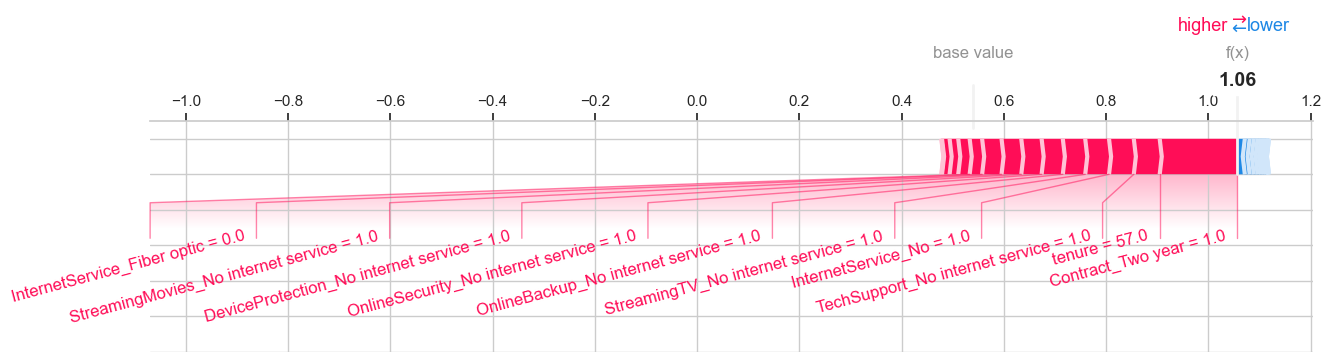

Label for instance 469: 0


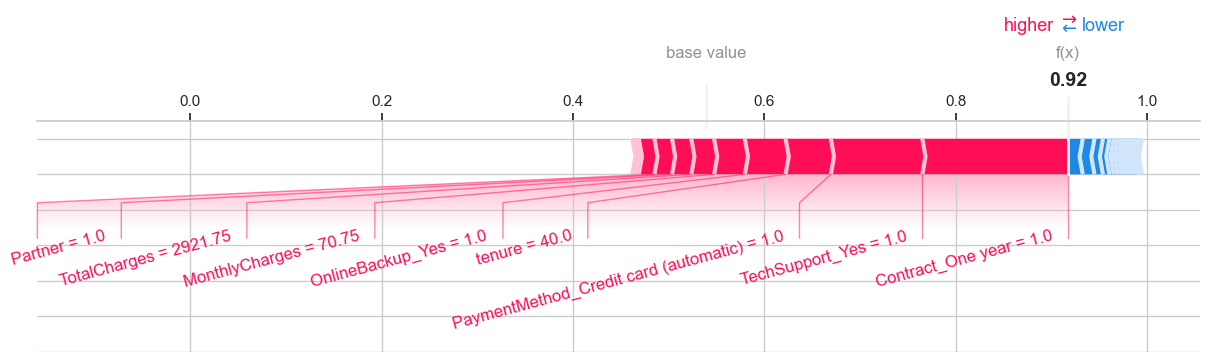

Label for instance 908: 0


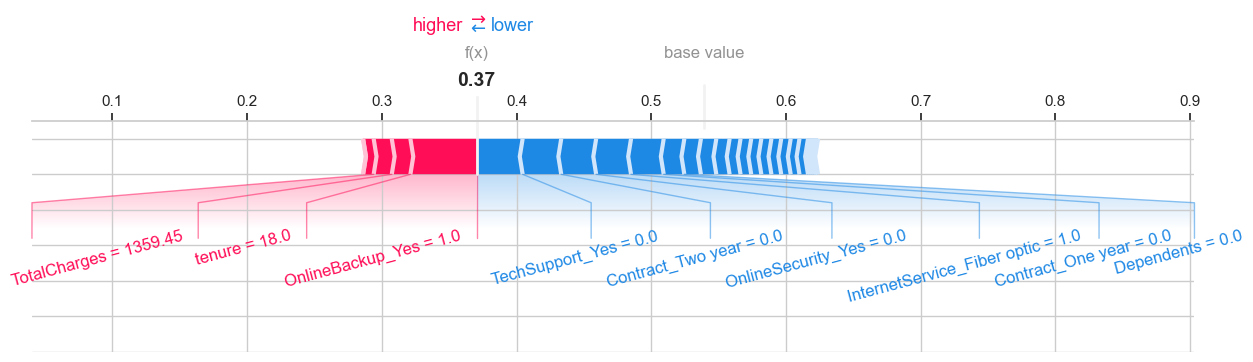

Label for instance 158: 1


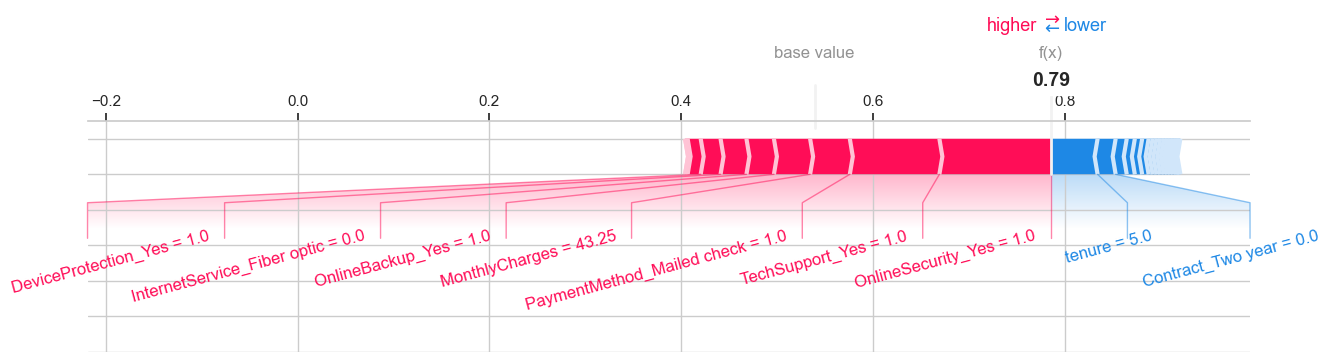

Label for instance 398: 0


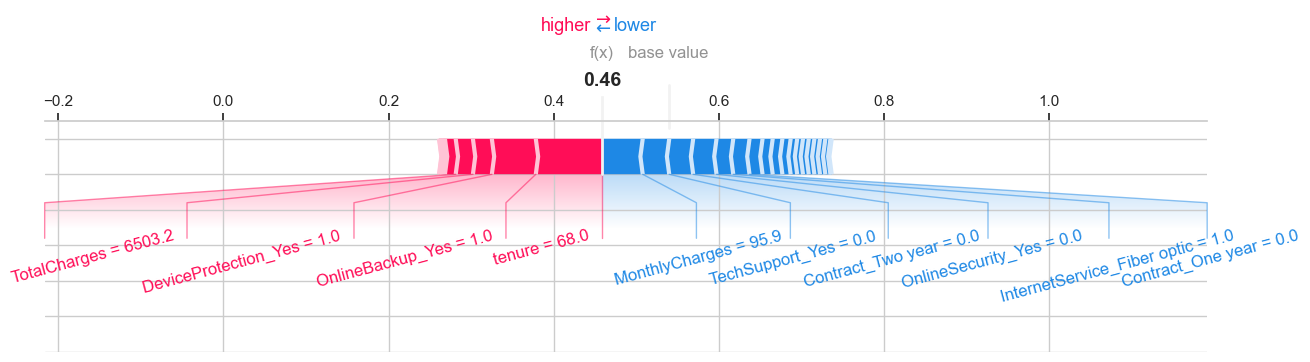

In [13]:
idx = [1094, 469, 908, 158, 398]
for i in [1094, 469, 908, 158, 398]:
    # Randomly sample an index from X_test

    # Get the corresponding instance and label
    instance = X_test.iloc[i:i+1]  # Single instance
    label = y_test.iloc[i]  # Corresponding label
    
    # Print out the label
    print(f"Label for instance {i}: {label}")
    
    # Generate SHAP values for the instance
    #shap_values = explainer(instance)
    
    # Plot the SHAP force plot for the sampled instance
    shap.force_plot(explainer_object.base_values[0][1], explainer_object.values[i,:,0], instance, matplotlib=True,text_rotation=15, figsize=(15,3))
    
    # Show the plot
    plt.show()

In [14]:
indices_list=[1094, 469, 908, 158, 398]
# Get the corresponding instances from X_test
instances = X_test.iloc[indices_list]

# Get the predicted probabilities for these instances
predicted_probabilities = trained_xai_model.predict_proba(instances)

# Print out the predicted probabilities for each instance
for idx, prob in zip(indices_list, predicted_probabilities):
    print(f"Instance {idx} - Predicted probability for class 1: {prob[1]}")
    
    # Check if the probability is approximately 0.4459
    if abs(prob[1] - 0.4459) < 0.01:  # A small tolerance to check closeness
        print(f"Instance {idx} has a predicted probability close to 0.4459")


Instance 1094 - Predicted probability for class 1: 0.027180419967595616
Instance 469 - Predicted probability for class 1: 0.13818213758647205
Instance 908 - Predicted probability for class 1: 0.7054561293381059
Instance 158 - Predicted probability for class 1: 0.28777158092624505
Instance 398 - Predicted probability for class 1: 0.6294323615102398


In [15]:
shap.force_plot(base_value=explainer_object.base_values[0][0], 
                shap_values=explainer_object.values[:,:,0],
                features=X_test)

## Global Interpretation

In [22]:
feature_names

['SeniorCitizen',
 'Partner',
 'Dependents',
 'tenure',
 'PaperlessBilling',
 'MonthlyCharges',
 'TotalCharges',
 'MultipleLines_No phone service',
 'MultipleLines_Yes',
 'InternetService_Fiber optic',
 'InternetService_No',
 'OnlineSecurity_No internet service',
 'OnlineSecurity_Yes',
 'OnlineBackup_No internet service',
 'OnlineBackup_Yes',
 'DeviceProtection_No internet service',
 'DeviceProtection_Yes',
 'TechSupport_No internet service',
 'TechSupport_Yes',
 'StreamingTV_No internet service',
 'StreamingTV_Yes',
 'StreamingMovies_No internet service',
 'StreamingMovies_Yes',
 'Contract_One year',
 'Contract_Two year',
 'PaymentMethod_Credit card (automatic)',
 'PaymentMethod_Electronic check',
 'PaymentMethod_Mailed check']

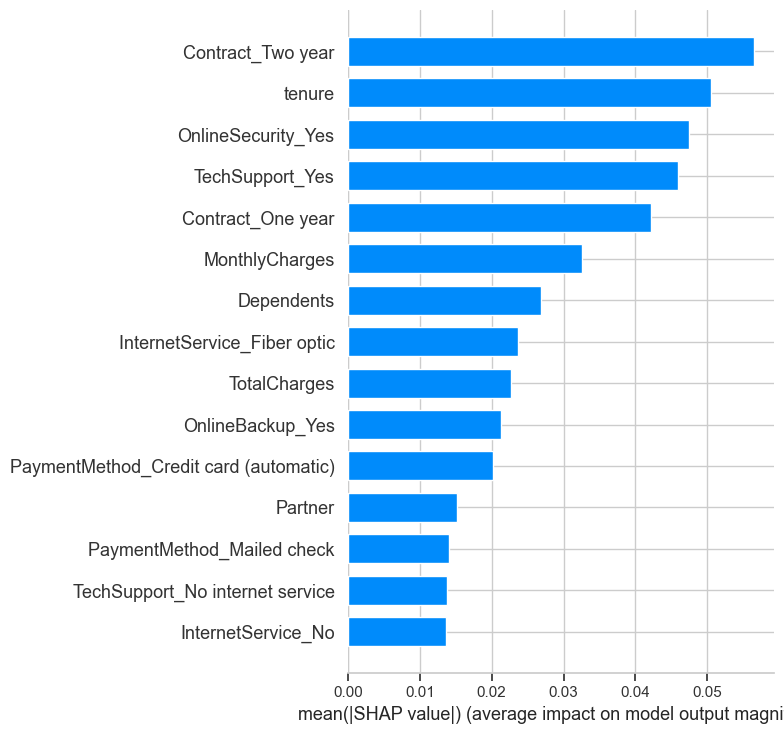

In [23]:
shap.summary_plot(shap_values=explainer_object.values[:,:,0],
                  features = X_test,
                  feature_names = feature_names,
                  max_display = 15,
                  plot_type = "bar")

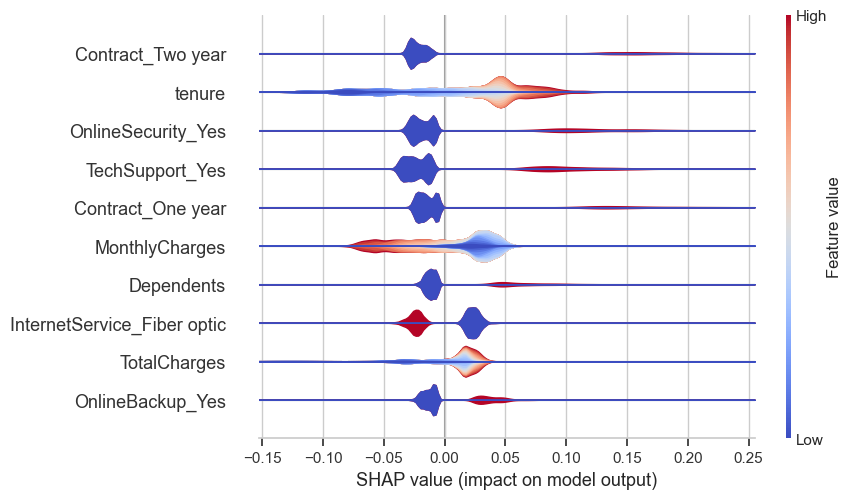

In [24]:
shap.plots.violin(shap_values=explainer_object.values[:,:,0], features=X_test, plot_type="layered_violin",max_display = 10)

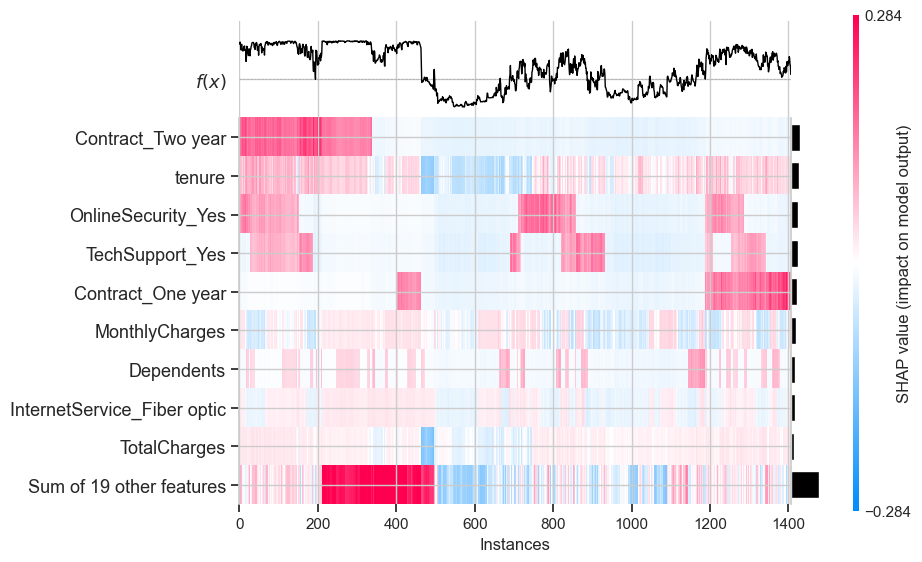

<Axes: xlabel='Instances'>

In [17]:
shap.plots.heatmap(shap_values=explainer_object[:,:,0], max_display=10)

In [18]:
feature_names = X_test.columns.to_list()

In [19]:
X_test["Contract_Two year"]

2476    1
6773    0
6116    0
3047    0
4092    0
       ..
1728    0
5241    0
5456    0
5842    0
3977    1
Name: Contract_Two year, Length: 1407, dtype: int64

In [20]:
explainer_object.values[:,:,0].shape

(1407, 28)

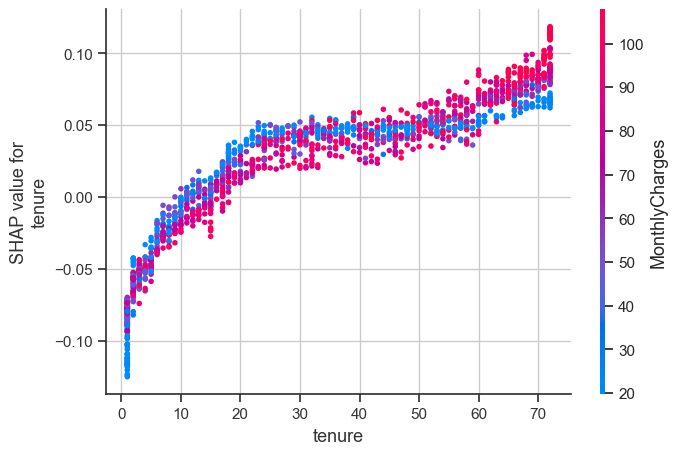

In [21]:
shap.dependence_plot(ind="tenure", shap_values=explainer_object.values[:,:,0],
                     features=X_test,feature_names=feature_names)

This SHAP dependence plot visualizes how the feature \texttt{tenure} affects the SHAP values (i.e., the model's predictions) for individual instances. There is a positive correlation between \texttt{tenure} and the SHAP value, indicating that as \texttt{tenure} increases, the SHAP value tends to increase. This suggests that customers with longer tenures contribute positively to the model’s predictions, possibly implying that longer-tenure customers are less likely to churn (if this is a churn prediction model) or are contributing to more favorable predictions. The color gradient represents \texttt{MonthlyCharges}, where blue indicates lower values and red indicates higher values. For the same \texttt{tenure}, instances with higher \texttt{MonthlyCharges} (in pink/red) tend to have higher SHAP values compared to instances with lower \texttt{MonthlyCharges} (in blue). This interaction suggests that customers with both higher \texttt{MonthlyCharges} and longer \texttt{tenure} have a stronger influence on predictions. The relationship between \texttt{tenure} and SHAP values is not entirely linear, especially for short tenures (less than 20 months), where there is significant variability in SHAP values. However, as \texttt{tenure} increases, the SHAP values stabilize and increase more consistently. In summary, \texttt{tenure} is a key factor in this model, and it interacts with \texttt{MonthlyCharges}, showing that customers with longer tenures and higher monthly charges contribute more positively to the predictions.


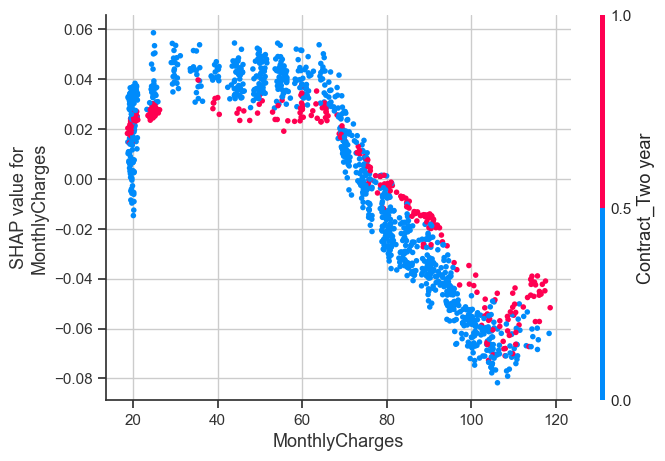

In [27]:
shap.dependence_plot(ind="MonthlyCharges", shap_values=explainer_object.values[:,:,0],
                     features=X_test,feature_names=feature_names)